# Fitting a Model with InSession

In [68]:
import os
import pandas as pd 
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"
df = pd.read_csv(file_path)

df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)

# Aggregate data  
df_weekly = df.set_index("DateReported").resample("W").agg({
    "InSession": "max"  # 1 if UVA was in session at least once that week, else 0
}).reset_index() 

# Add the CrimeCount column by counting rows per week
df_weekly["CrimeCount"] = df.resample("W", on="DateReported").size().values


# Rename columns for Prophet
df_weekly = df_weekly.rename(columns={"DateReported": "ds", "CrimeCount": "y"})

# Sort by date
df_weekly = df_weekly.sort_values("ds")

# Ensure 'ds' is in datetime format and remove timezone
df_weekly["ds"] = pd.to_datetime(df_weekly["ds"]).dt.tz_localize(None)

# Initialize model
model1 = Prophet(
    yearly_seasonality=True,  # Enable annual seasonality
    weekly_seasonality=True,  # Enable weekly seasonality
    daily_seasonality=False,  # Disable daily since it's too granular
)

# Add UVA regressor
model1.add_regressor("InSession")

# Fit model
model1.fit(df_weekly)

future1 = model1.make_future_dataframe(periods=52, freq="W")  # Predict 1 year ahead

# Add UVA session indicator to future data
future1["InSession"] = future1["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Predict
forecast1 = model1.predict(future1)

# Display forecast
forecast1[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()


/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_33242/2053023618.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
14:21:25 - cmdstanpy - INFO - Chain [1] start processing
14:21:25 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2019-10-06,78.322721,58.662880,98.218941
1,2019-10-13,81.588148,62.147239,102.141088
2,2019-10-20,89.967986,72.060514,109.163450
3,2019-10-27,95.457429,74.147649,114.510565
4,2019-11-03,92.107875,69.666616,111.170397


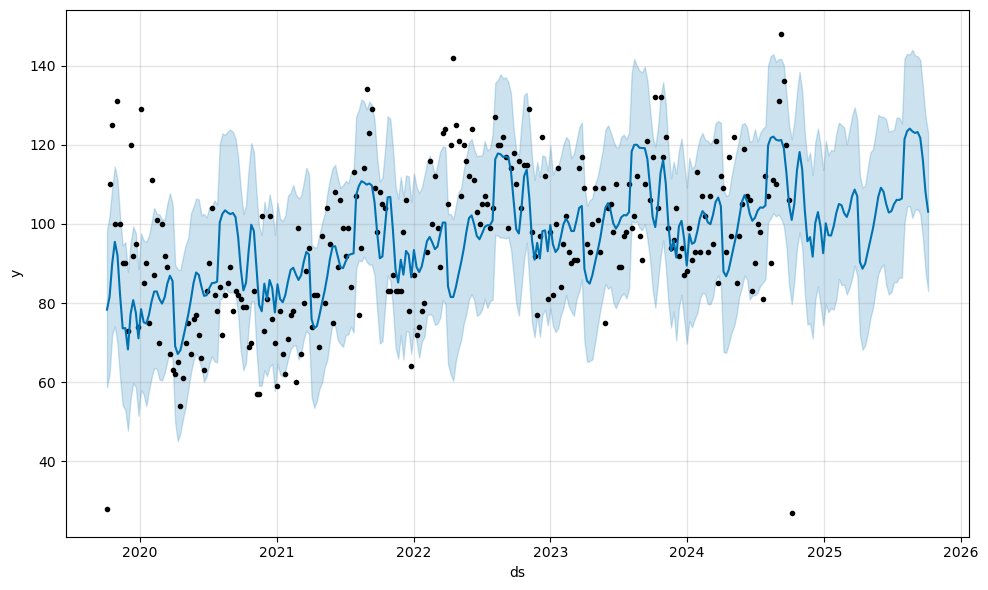

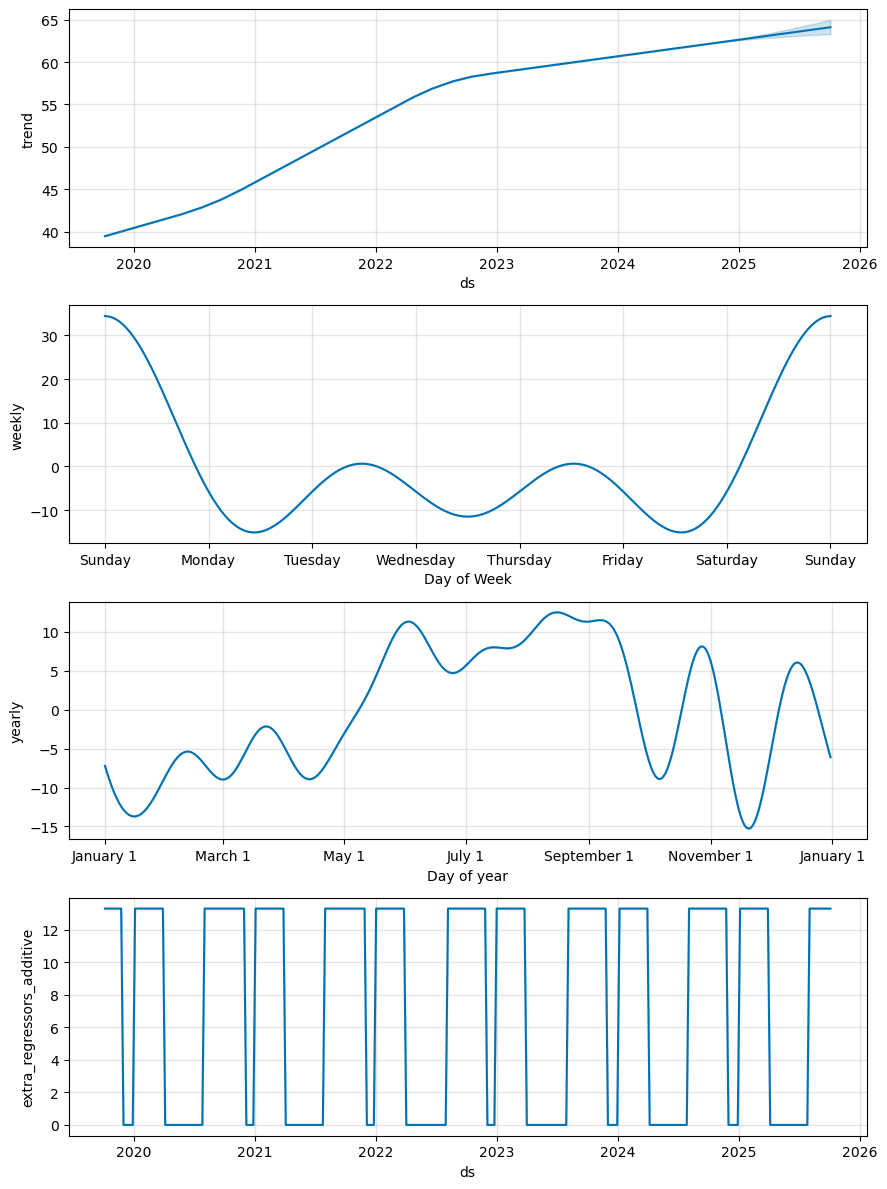

In [69]:
import matplotlib.pyplot as plt

# Plot forecast
fig = model1.plot(forecast1)
plt.show()

# Plot seasonality components
fig2 = model1.plot_components(forecast1)
plt.show()


In [70]:
# Evaluate model 

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# Use past data for testing
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

model_val1 = Prophet(
    yearly_seasonality=True,  # Enable annual seasonality
    weekly_seasonality=True,  # Enable weekly seasonality
    daily_seasonality=False,  # Disable daily since it's too granular
)

# Fit on training set
model_val1.fit(train)

# Predict on test set
test_forecast1 = model_val1.predict(test)

# Evaluate
mae1 = mean_absolute_error(test["y"], test_forecast1["yhat"])
rmse1 = root_mean_squared_error(test["y"], test_forecast1["yhat"])
mape1 = mean_absolute_percentage_error(test["y"], test_forecast1["yhat"])

print(f"MAE: {mae1}")
print(f"RMSE: {rmse1}")
print(f"MAPE: {mape1}")


14:21:26 - cmdstanpy - INFO - Chain [1] start processing
14:21:26 - cmdstanpy - INFO - Chain [1] done processing


MAE: 12.221739029161725
RMSE: 17.571802007269326
MAPE: 0.16480361748447173


# Fitting a Model with Holidays (no InSession)

In [71]:
import os
import pandas as pd 
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"
df = pd.read_csv(file_path)

df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
df_weekly = df.resample("W", on="DateReported").size().reset_index()
df_weekly = df_weekly.rename(columns={"DateReported": "ds", 0: "y"})
df_weekly["ds"] = df_weekly["ds"].dt.tz_localize(None)
df_weekly = df_weekly.sort_values("ds")

# Define UVA holidays 
uva_holidays = []
start_year, end_year = 2019, 2023

for year in range(start_year, end_year + 1):
    uva_holidays.extend([
        {"holiday": "Fall semester start", "ds": f"{year}-08-24"},
        {"holiday": "Fall semester end", "ds": f"{year}-12-06"},
        {"holiday": "Winter break start", "ds": f"{year}-12-07"},
        {"holiday": "Winter break end", "ds": f"{year}-01-17"},
        {"holiday": "Spring semester start", "ds": f"{year}-01-18"},
        {"holiday": "Spring semester end", "ds": f"{year}-05-02"},
        {"holiday": "Summer break start", "ds": f"{year}-05-03"},
        {"holiday": "Summer break end", "ds": f"{year}-08-23"},
    ])

# Convert holidays to DataFrame with window effects
uva_holidays = pd.DataFrame(uva_holidays)
uva_holidays["ds"] = pd.to_datetime(uva_holidays["ds"])
uva_holidays["lower_window"] = uva_holidays["holiday"].apply(lambda x: -5 if "break" in x else -2)
uva_holidays["upper_window"] = uva_holidays["holiday"].apply(lambda x: 5 if "break" in x else 2)

# Initialize Prophet model with holidays
model2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays  # Incorporate UVA holidays
)

# Fit model
df_weekly["ds"] = pd.to_datetime(df_weekly["ds"]).dt.tz_localize(None)
model2.fit(df_weekly)

# Make future predictions
future2 = model2.make_future_dataframe(periods=104, freq="W")
forecast2 = model2.predict(future2)

# Display forecast
forecast2[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()


/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_33242/2145962873.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
14:21:26 - cmdstanpy - INFO - Chain [1] start processing
14:21:26 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2019-10-06,75.842112,56.584166,95.357892
1,2019-10-13,80.626253,61.837883,99.727746
2,2019-10-20,89.593809,70.826252,108.417179
3,2019-10-27,94.106372,74.279285,113.533538
4,2019-11-03,89.663119,70.432378,109.276882


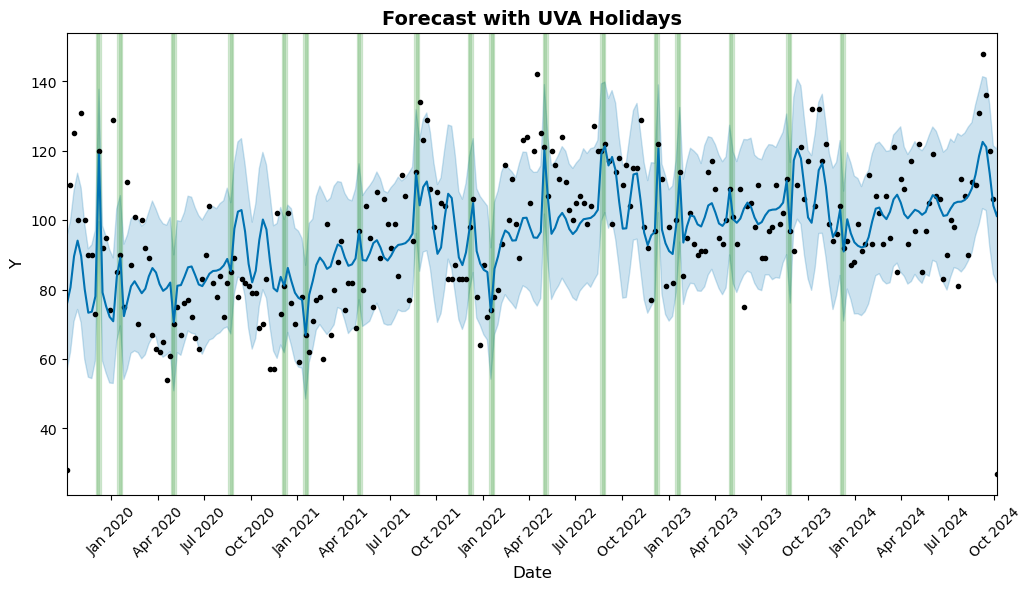

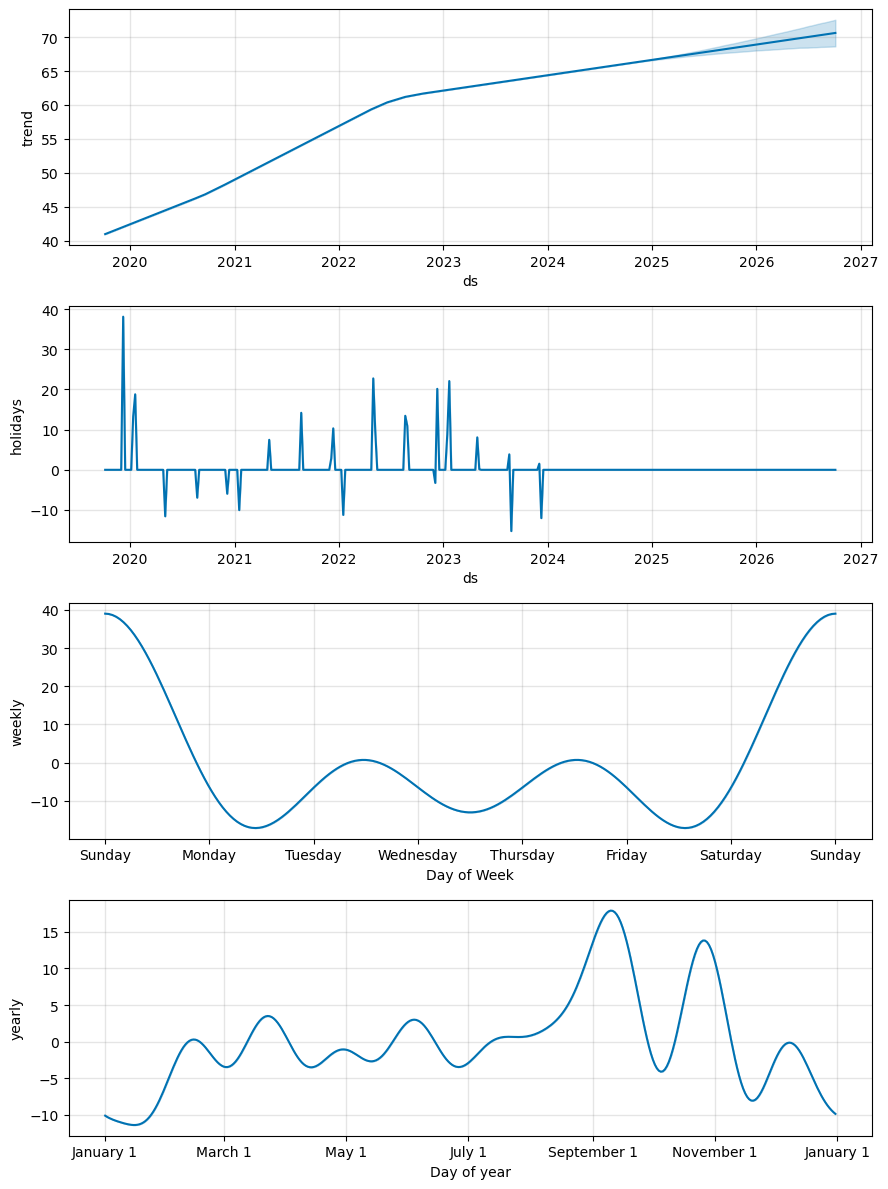

In [72]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Define the cutoff date for plotting
cutoff_date = pd.Timestamp("2019-10-06")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))


model2.plot(forecast2, ax=ax)
ax.get_lines()[0].set_linewidth(2)  

ax.set_xlim([cutoff_date, df_weekly["ds"].max()])

# Shade holidays
for _, row in uva_holidays.iterrows():
    holiday_start = row["ds"] + pd.Timedelta(days=row["lower_window"])
    holiday_end = row["ds"] + pd.Timedelta(days=row["upper_window"])
    
    if holiday_end >= cutoff_date:
        ax.axvspan(holiday_start, holiday_end, color="green", alpha=0.15)  # Softer shading

ax.get_children()[-1].set_alpha(0.6)  # Reduce opacity of scatter points

# Format x-axis labels for every 6 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2021", "Jul 2021"

plt.xticks(rotation=45)

ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_title("Forecast with UVA Holidays", fontsize=14, fontweight="bold")

# Show the plot
ax.grid(False) # Hide grid lines
plt.show()

# Plot seasonality components
fig2 = model2.plot_components(forecast2)
plt.show()


In [73]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# Validation 
# Split dataset for validation
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

# Initialize new Prophet model for validation
model_val2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays  # Include holidays in validation model
)

# Fit model on training set
model_val2.fit(train)

# Predict on test set
test_forecast2 = model_val2.predict(test)

# Evaluate model
mae2 = mean_absolute_error(test["y"], test_forecast2["yhat"])
rmse2 = root_mean_squared_error(test["y"], test_forecast2["yhat"])
mape2 = mean_absolute_percentage_error(test["y"], test_forecast2["yhat"])

print(f"\nMAE: {mae2}")
print(f"RMSE: {rmse2}")
print(f"MAPE: {mape2}")


14:21:27 - cmdstanpy - INFO - Chain [1] start processing
14:21:27 - cmdstanpy - INFO - Chain [1] done processing



MAE: 11.820485635491181
RMSE: 17.310910064515372
MAPE: 0.16044533874170602


# Fitting a Model with InSession *and* Holidays

In [74]:
import os
import pandas as pd 
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"
df = pd.read_csv(file_path)

df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)

# Resample weekly, counting occurrences
# Aggregate weekly crime counts
df_weekly = df.resample("W", on="DateReported").size().reset_index(name="y")
df_weekly = df_weekly.rename(columns={"DateReported": "ds"})

df_weekly["ds"] = df_weekly["ds"].dt.tz_localize(None)
df_weekly = df_weekly.sort_values("ds")

# Add InSession indicator
df_weekly["InSession"] = df_weekly["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Define UVA holidays 
uva_holidays = []
start_year, end_year = 2019, 2023

for year in range(start_year, end_year + 1):
    uva_holidays.extend([
        {"holiday": "Fall semester start", "ds": f"{year}-08-24"},
        {"holiday": "Fall semester end", "ds": f"{year}-12-06"},
        {"holiday": "Winter break start", "ds": f"{year}-12-07"},
        {"holiday": "Winter break end", "ds": f"{year}-01-17"},
        {"holiday": "Spring semester start", "ds": f"{year}-01-18"},
        {"holiday": "Spring semester end", "ds": f"{year}-05-02"},
        {"holiday": "Summer break start", "ds": f"{year}-05-03"},
        {"holiday": "Summer break end", "ds": f"{year}-08-23"},
    ])

# Convert holidays to DataFrame with window effects
uva_holidays = pd.DataFrame(uva_holidays)
uva_holidays["ds"] = pd.to_datetime(uva_holidays["ds"])
uva_holidays["lower_window"] = uva_holidays["holiday"].apply(lambda x: -5 if "break" in x else -2)
uva_holidays["upper_window"] = uva_holidays["holiday"].apply(lambda x: 5 if "break" in x else 2)

# Initialize and fit the Prophet model
model3 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays
)

# Add InSession as a regressor
model3.add_regressor("InSession")

# Fit model
model3.fit(df_weekly)

# Create future dataframe
future = model3.make_future_dataframe(periods=52, freq="W")  # Weekly predictions for 1 year

# Add InSession to future data
future["InSession"] = future["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Predict
forecast3 = model3.predict(future)

# Show forecast
forecast3[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_33242/3373956140.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
14:21:28 - cmdstanpy - INFO - Chain [1] start processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2019-10-06,76.560958,58.109451,94.313211
1,2019-10-13,81.134478,62.310182,100.345022
2,2019-10-20,90.013255,71.112698,108.571133
3,2019-10-27,94.711356,74.785926,114.778121
4,2019-11-03,90.381005,69.835927,109.580291


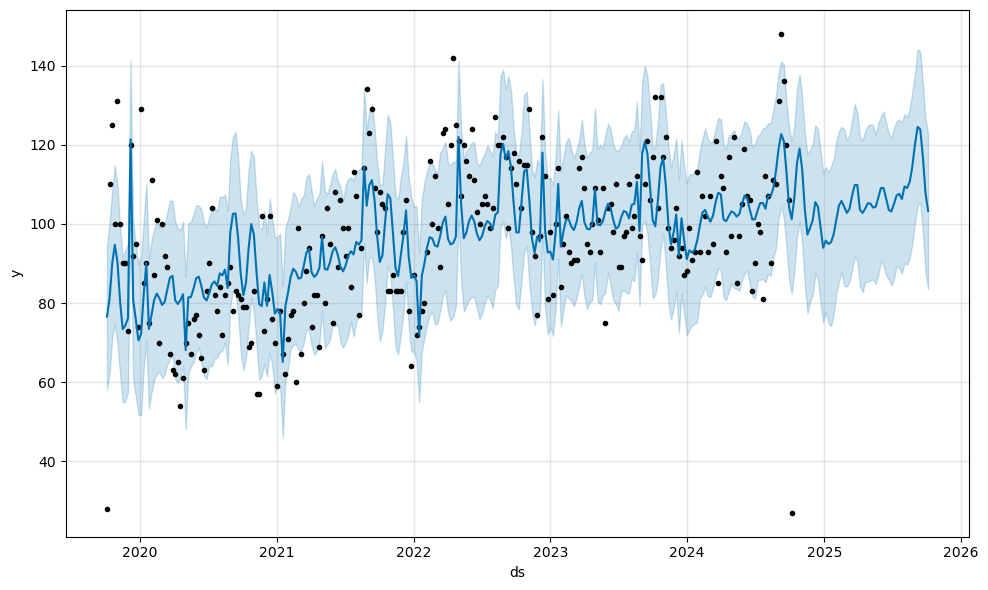

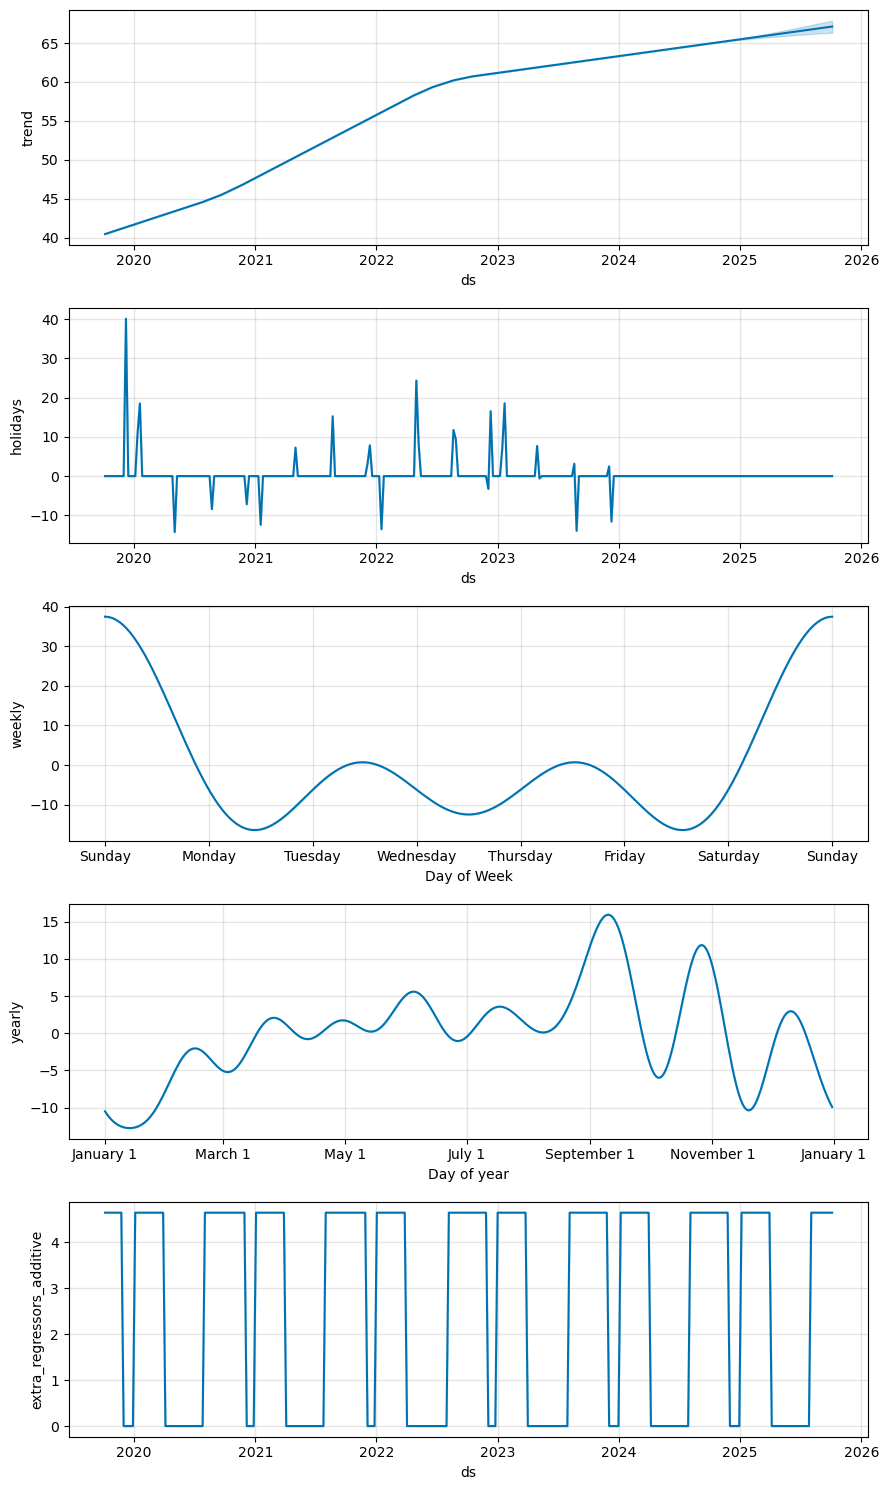

In [75]:
# Visualize forecast 
import matplotlib.pyplot as plt

# Plot forecast
fig = model3.plot(forecast3)
plt.show()

# Plot seasonality components
fig2 = model3.plot_components(forecast3)
plt.show()


In [76]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# Validation 
# Split dataset for validation
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

# Initialize new Prophet model for validation
model_val3 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays  # Include holidays in validation model
)

# Fit model on training set
model_val3.fit(train)

# Predict on test set
test_forecast3 = model_val3.predict(test)

# Evaluate model
mae3 = mean_absolute_error(test["y"], test_forecast3["yhat"])
rmse3 = root_mean_squared_error(test["y"], test_forecast3["yhat"])
mape3 = mean_absolute_percentage_error(test["y"], test_forecast3["yhat"])

print(f"Mean Absolute Error (MAE): {mae3}")
print(f"Root Mean Squared Error (RMSE): {rmse3}")
print(f"Mean Absolute Percentage Error (MAPE): {mape3}")


14:21:28 - cmdstanpy - INFO - Chain [1] start processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 11.820485635491181
Root Mean Squared Error (RMSE): 17.310910064515372
Mean Absolute Percentage Error (MAPE): 0.16044533874170602


# Comparing the Models

In [78]:
comp_df = pd.DataFrame({
    "Mean Absolute Error (MAE)": [mae1, mae2, mae3], 
    "Root Mean Squared Error (RMSE)": [rmse1, rmse2, rmse3],
    "Mean Absolute Percentage Error (MAPE)": [mape1, mape2, mape3]
}, index=["InSession", "Holidays", "InSession + Holidays"])

comp_df


,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE),Mean Absolute Percentage Error (MAPE)
InSession,12.221739,17.571802,0.164804
Holidays,11.820486,17.310910,0.160445
InSession + Holidays,11.820486,17.310910,0.160445


# To-Do 
1. Double-check Holidays and Holidays + InSession model. 
2. See if we can add InSession dates to visualizations. 